# CosmoFlow Benchmark Scaling Analysis

In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

def compute_mean_time(r):
    return r[r.epoch>0].time.mean()

def get_num_samples(config):
    dc = config['data']
    return dc['n_train'] + dc['n_valid']

In [4]:
ls $SCRATCH/cosmoflow-benchmark/

cosmoflow-001/            cosmoflow-19-10-23/       scaling-dummy-n2/
cosmoflow-19-06-11/       cosmoflow-19-10-24/       scaling-dummy-n256/
cosmoflow-19-06-12/       cosmoflow-resnet/         scaling-dummy-n32/
cosmoflow-19-06-13/       cosmoflow-test/           scaling-dummy-n4/
cosmoflow-19-06-17/       cosmoflow-v2-2019-10-22/  scaling-dummy-n512/
cosmoflow-19-06-19/       cosmoflow-v2-2019-10-24/  scaling-dummy-n64/
cosmoflow-19-06-22-1gpu/  data/                     scaling-dummy-n8/
cosmoflow-19-06-22-test/  scaling-cgpu-n1/          scaling-n1/
cosmoflow-19-06-24/       scaling-cgpu-n16/         scaling-n1024/
cosmoflow-19-06-25/       scaling-cgpu-n2/          scaling-n128/
cosmoflow-19-06-25-cpu/   scaling-cgpu-n32/         scaling-n16/
cosmoflow-19-07-13-cpu/   scaling-cgpu-n4/          scaling-n2/
cosmoflow-19-08-17-cpu/   scaling-cgpu-n64/         scaling-n256/
cosmoflow-19-08-17-gpu/   scaling-cgpu-n8/          scaling-n32/
cosmoflow-19-08-30-gpu/   scaling-dummy-n1/    

## Cori GPU scaling

In [8]:
plt.rcParams.update({'font.size': 14})

In [7]:
ranks = np.array([1, 2, 4, 8])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-cgpu-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c) for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_cgpu = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                 times=times, throughputs=throughputs))

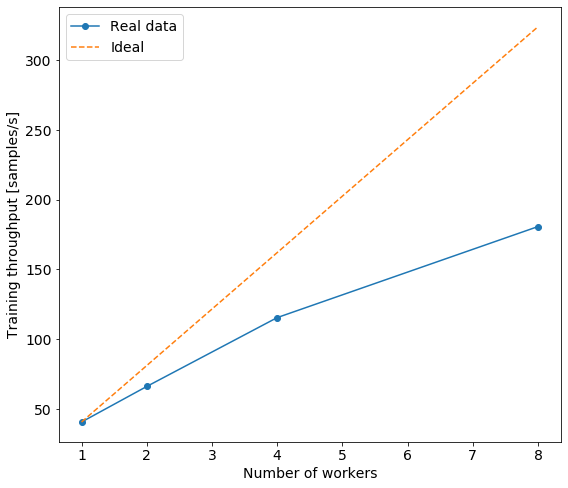

In [9]:
plt.figure(figsize=(9,8))
plt.plot(scaling_cgpu.ranks, scaling_cgpu.throughputs, 'o-', label='Real data')
#plt.plot(scaling_dummy['ranks'], scaling_dummy['throughputs'], '^-', label='Dummy data')
plt.xlabel('Number of workers')
plt.ylabel('Training throughput [samples/s]')

plt.plot(scaling_cgpu.ranks, scaling_cgpu.ranks*scaling_cgpu.throughputs[0], '--', label='Ideal')
plt.legend(loc=0);

In [10]:
ranks = np.array([8, 16, 32, 64])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-cgpu-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c) for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_cgpu = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                 times=times, throughputs=throughputs))

In [12]:
scaling_cgpu

,ranks,samples,times,throughputs
0,8,2048,11.332243,180.723263
1,16,4096,11.211234,365.347839
2,32,4096,5.696604,719.024897
3,64,4096,2.673358,1532.155278


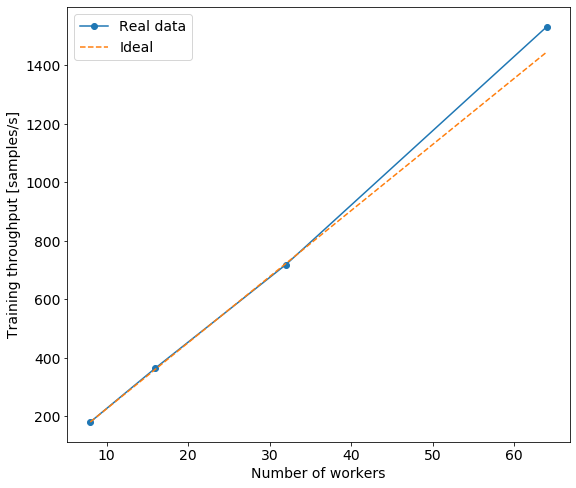

In [14]:
plt.figure(figsize=(9,8))
plt.plot(scaling_cgpu.ranks, scaling_cgpu.throughputs, 'o-', label='Real data')
#plt.plot(scaling_dummy['ranks'], scaling_dummy['throughputs'], '^-', label='Dummy data')
plt.xlabel('Number of workers')
plt.ylabel('Training throughput [samples/s]')

plt.plot(scaling_cgpu.ranks, scaling_cgpu.ranks*scaling_cgpu.throughputs[0]/8, '--', label='Ideal')
plt.legend(loc=0);

## Cori CPU scaling

In [5]:
ranks = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-dummy-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c)*r for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_dummy = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                  times=times, throughputs=throughputs))

In [6]:
ranks = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c) for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_scratch = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                    times=times, throughputs=throughputs))

In [7]:
plt.rcParams.update({'font.size': 14})

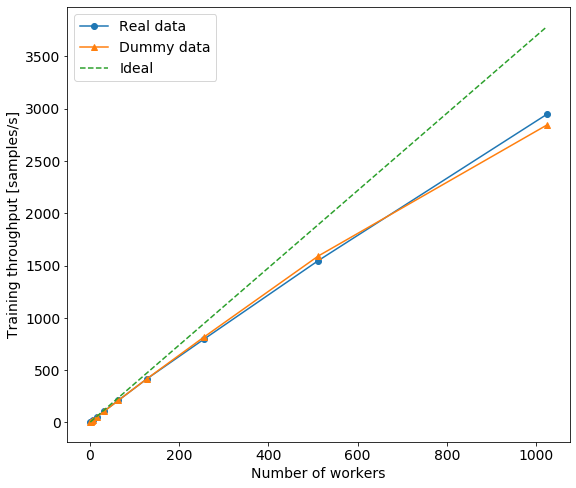

In [14]:
plt.figure(figsize=(9,8))
plt.plot(scaling_scratch['ranks'], scaling_scratch['throughputs'], 'o-', label='Real data')
plt.plot(scaling_dummy['ranks'], scaling_dummy['throughputs'], '^-', label='Dummy data')
#plt.plot(scaling_dwarp['ranks'], scaling_dwarp['throughputs'], 'o-', label='DWarp')
plt.xlabel('Number of workers')
plt.ylabel('Training throughput [samples/s]')

plt.plot(scaling_scratch.ranks, scaling_scratch.ranks*scaling_scratch['throughputs'][0], '--', label='Ideal')
#plt.plot(ranks, ranks*scaling_dummy['throughputs'][0], '--', label='Ideal')
plt.legend(loc=0);

In [15]:
scaling_scratch

,ranks,samples,times,throughputs
0,1,64,17.317688,3.695643
1,2,128,18.528065,6.908439
2,4,256,18.764791,13.642571
3,8,512,18.910925,27.074297
4,16,1024,19.091434,53.636619
5,32,2048,19.181881,106.767423
6,64,4096,19.419858,210.918124
7,128,8192,19.644668,417.008818
8,256,16384,20.561300,796.836774
9,512,32768,21.172881,1547.640124


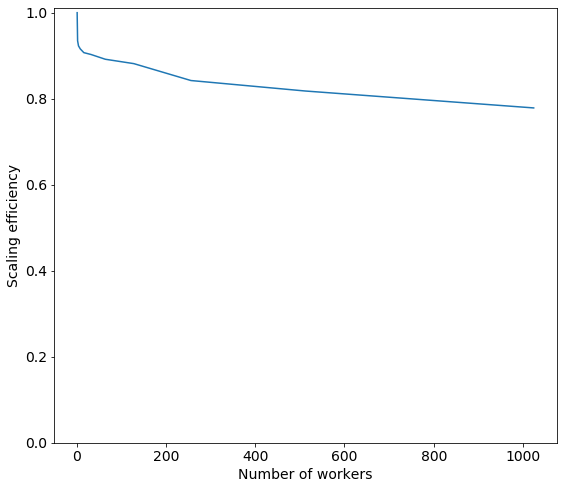

In [16]:
# Plot scaling efficiency
plt.figure(figsize=(9,8))
eff = scaling_scratch.throughputs / (scaling_scratch.ranks * scaling_scratch.throughputs.loc[0])

plt.plot(scaling_scratch.ranks, eff)
plt.xlabel('Number of workers')
plt.ylabel('Scaling efficiency')
plt.ylim(bottom=0.);

## Discussion

The scaling performance looks pretty decent, achieving about 80% of ideal throughput speedup at 1k nodes.

The data pipeline seems well tuned. We are not even using the Burst Buffer, but the scaling is about as good as with dummy data.